# PRACTICA GUIADA 1: Agregando y agrupando datos

* La sumarización es parte fundamental del análisis: computar medidas como ``sum()``, ``mean()``, ``median()``, ``min()`` y ``max()`` son tareas básicas para comenzar a explorar un dataset.

* En esta sección veremos algunas opciones para realizar agregaciones de datos en Pandas.

* La siguiente función ``display`` solamente sirve para desplegar y hacer más gráficos los resultados del código. No tiene ninguna otra utilidad práctica.

In [1]:
import numpy as np
import pandas as pd

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Dataset Planets

* Usaremos el siguiente dataset disponible en el [Seaborn package](http://seaborn.pydata.org/).

* Contiene información sobre los planetas que los astrónomos fueron descubriendo a lo largo de los años:

In [2]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [3]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


## Agregaciones simples en Pandas

* Al igual que en un array de una dimensiónpara una ``Series`` la agregación devuelve un valor único

In [4]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [5]:
ser.sum()

2.811925491708157

In [6]:
ser.mean()

0.5623850983416314

* Para un ``DataFrame``, los `aggregate` retornan por default resultados al interior de cada columna:

In [7]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [8]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

* Especificando el argumento ``axis`` es posible agregar los resultados para cada fila.

**Nota:** Al igual que en el caso de NumPy, en `axis` se define la dimensión sobre la que se colapsan los datos. Si quiero resultados por fila, entonces, `axis='columns` y viceversa

In [9]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

* Las ``Series`` y ``DataFrame`` de Pandas incluyen muchas funciones de agregación.

* Hay, además, un método ``describe()`` que computa algunas medidas agregadas por defecto para cada columna y devuelve un `DataFrame` como resultado.

* Usemos el dataset de `planets` eliminando los datos perdidos:

In [10]:
planets.describe()

,number,orbital_period,mass,distance,year
count,1035.000000,992.000000,513.000000,808.000000,1035.000000
mean,1.785507,2002.917596,2.638161,264.069282,2009.070531
std,1.240976,26014.728304,3.818617,733.116493,3.972567
min,1.000000,0.090706,0.003600,1.350000,1989.000000
25%,1.000000,5.442540,0.229000,32.560000,2007.000000
50%,1.000000,39.979500,1.260000,55.250000,2010.000000
75%,2.000000,526.005000,3.040000,178.500000,2012.000000
max,7.000000,730000.000000,25.000000,8500.000000,2014.000000


In [11]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


* ¿Qué pueden decir de estos datos?

Resumen de algunas funciones de agregación en Pandas:

| Aggregation              | Description                     |
|--------------------------|---------------------------------|
| ``count()``              | Total number of items           |
| ``mean()``, ``median()`` | Mean and median                 |
| ``min()``, ``max()``     | Minimum and maximum             |
| ``std()``, ``var()``     | Standard deviation and variance |
| ``mad()``                | Mean absolute deviation         |
| ``prod()``               | Product of all items            |
| ``sum()``                | Sum of all items                |

Todos son métodos de los objetos ``DataFrame`` y ``Series``.

* Muchas veces esto no es suficiente y es necesario usar otras operaciones de sumarización.
* La operación ``groupby`` permite computar medidas agregadas de forma eficente en subsets de los datos.

## GroupBy: Split, Apply, Combine

* Muchas veces es importante poder realizar operaciones de agregación de forma condicional a algún subconjunto de datos (por ejemplo, para los casos que cumplen alguna condición). Esto es implementado por el operador `groupby`
* El nombre `groupby` proviene del lenguaje SQL (que ya abordaremos en el curso).
* Es útil pensarlo en los términos de Hadley Wickham: *split, apply, combine* (dividir-aplicar-combinar)

### Split, apply, combine

file:///home/digitalhouse/Descargas/splitapplycombine.png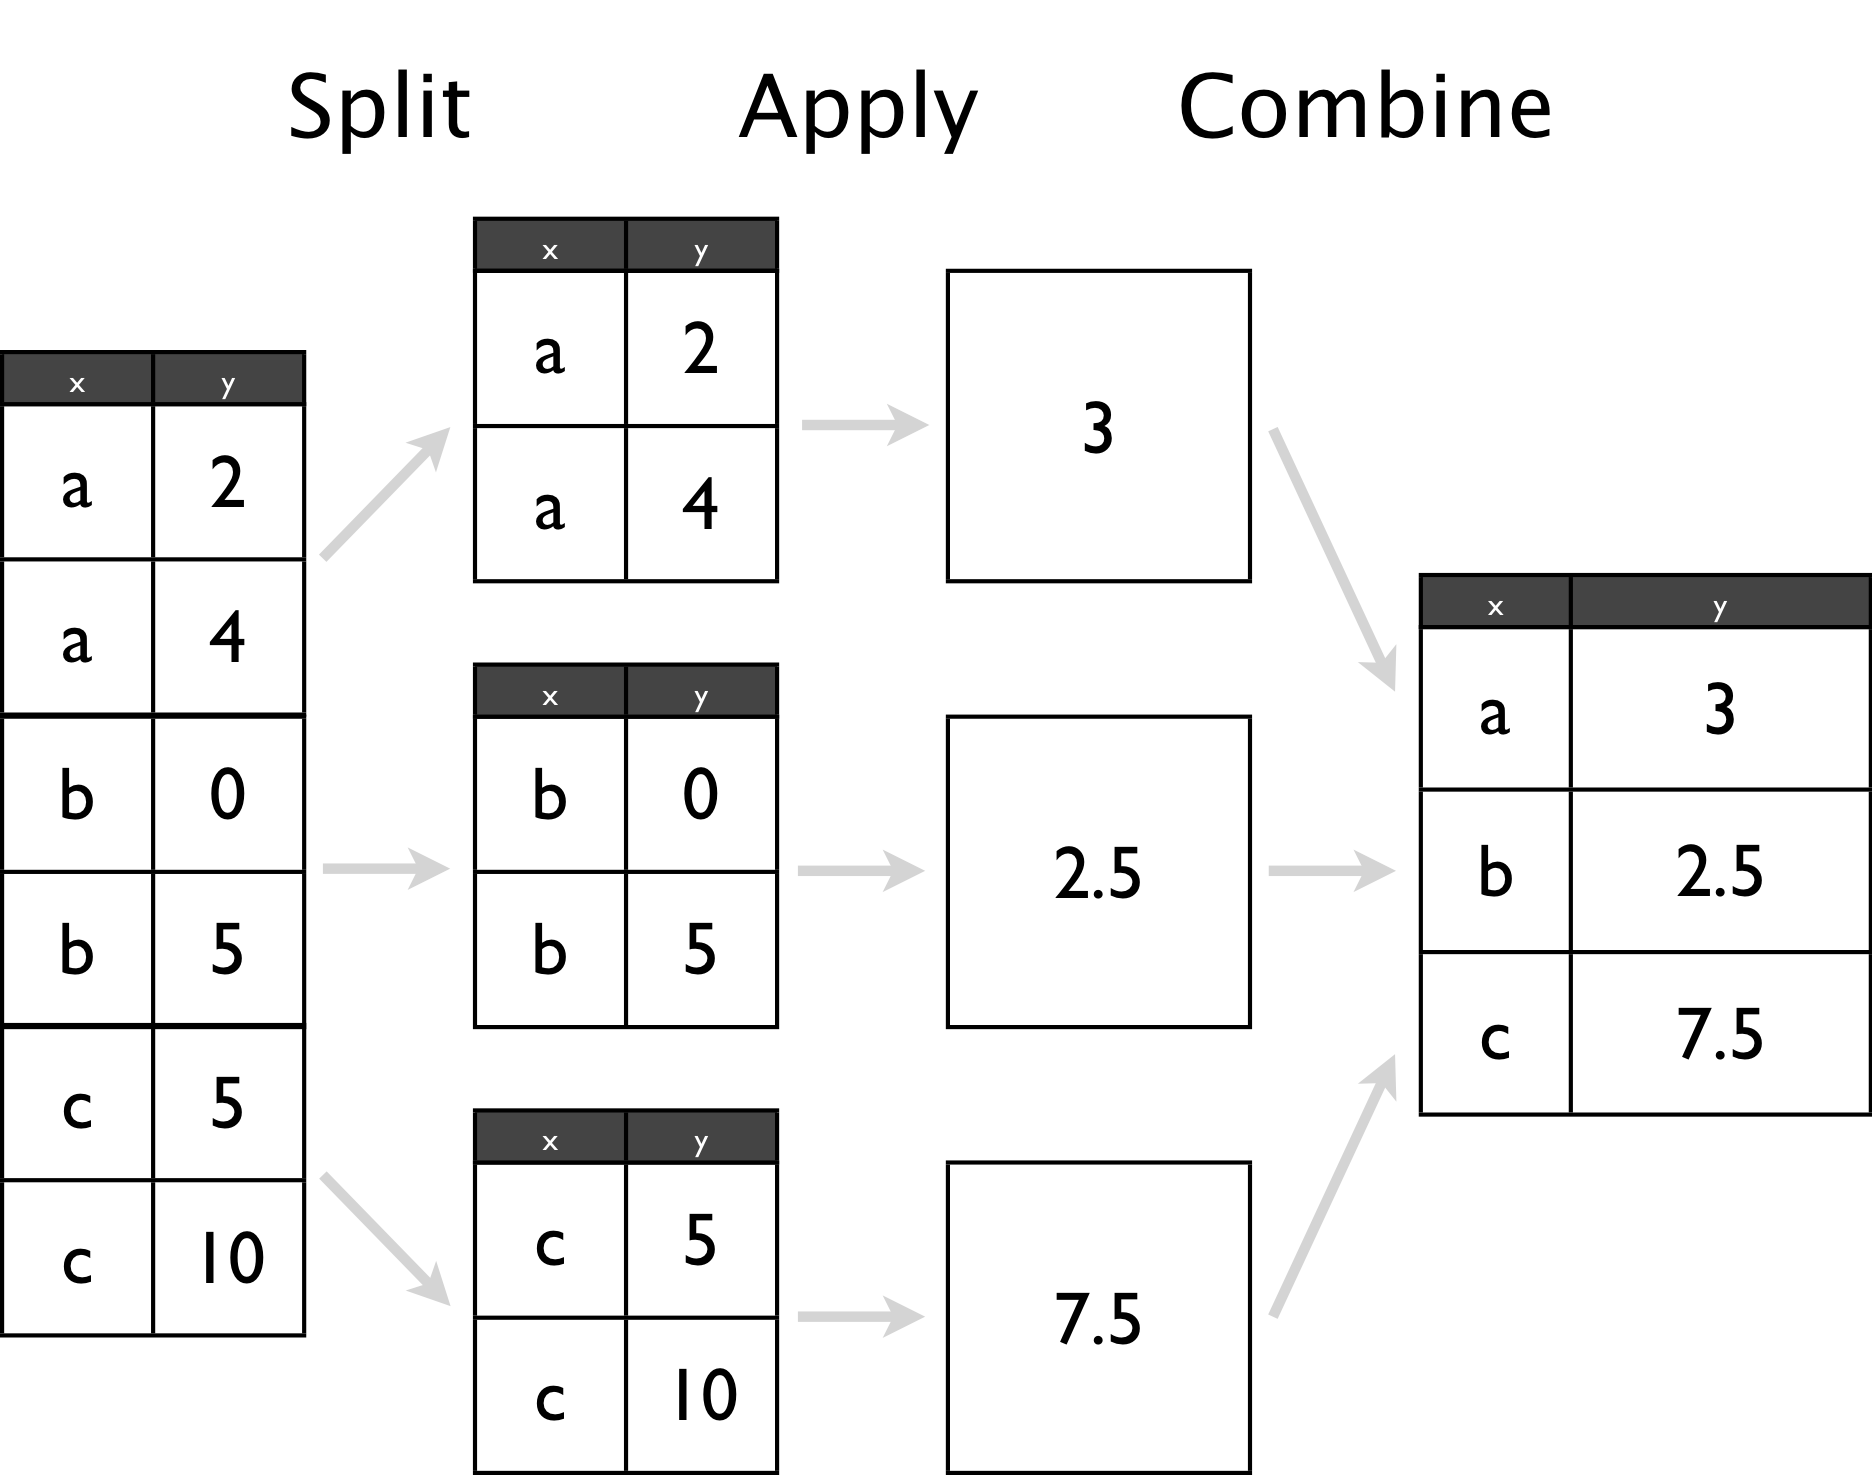


- El paso *split*  implica dividir y reagrupar un ``DataFrame`` en base a una determinada key.
- El paso *apply* supone computar alguna función (generalmente, alguna agregación, transformación o filtro) sobre los grupos constituidos en el paso anterior.
- El paso *combine* hace un "merge" de los resultados de dichas operaciones en un nuevo array.

* Si bien cada uno de los pasos pueden hacerse "manualmente", el ``GroupBy`` generalmente puede hacerlo en un solo paso.
* La ventaja del ``GroupBy`` es que permite abstraer los tres pasos anteriores: el usuario no necesita pensar en "cómo" hacer el cómputo, sino más bien pensar la operación como un todo.

In [12]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


* La operación split-apply-combine más básica con el método ``groupby()`` es pasar el nombre de una determinada clave de columna:

In [13]:
df.groupby('key')

* Notar que no se retorna un ``DataFrame`` sino un objeto ``DataFrameGroupBy``.
* Se puede pensar en el `DataFrameGroupBy` como una vista especial de un `DataFrame` que construye los grupos pero que no realiza ningún cómputo hasta que la etapa de agregación es aplicada.
* Esta **"lazy evaluation"** hace que las operaciones de agregación puedan ser computadas de forma muy eficiente.
* Para producir un resultado podemos aplicar una función de agregación a este ``DataFrameGroupBy`` que a realizar la operación (apply) y avanzar en el paso de combine.

In [14]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


* Se podría realizar virtualmente cualquier operación común de agregación de Pandas o NumPy y casi cualquier operación válida para un `DataFrame` como veremos a continuación.

### El objeto GroupBy

* El objeto ``GroupBy`` es un abstracción muy flexible.
* Puede ser tratado como una colección de `DataFrame` y hace algunas cosas complicadas por detrás...
* Quizá las operaciones más importantes de un objeto ``GroupBy`` sean las *aggregate*, *filter*, *transform*, y *apply*

#### Indexing de columnas

* El objeto ``GroupBy`` soporta el indexado de coumnas de la misma forma que un ``DataFrame``, y devuelve un objeto ``GroupBy`` modificado:

In [27]:
planets['method'].unique()

array(['Radial Velocity', 'Imaging', 'Eclipse Timing Variations',
       'Transit', 'Astrometry', 'Transit Timing Variations',
       'Orbital Brightness Modulation', 'Microlensing', 'Pulsar Timing',
       'Pulsation Timing Variations'], dtype=object)

In [15]:
planets.groupby('method')

In [16]:
planets.groupby('method')['orbital_period']

* Seleccionamos una ``Series`` particular del  ``DataFrame`` original referenciándolo con su nombre de columna.
* Al igual que antes, no se realiza ningún cómputo hasta que llamamos alguna función de agregación sobre el objeto.

In [22]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

* ¿Qué se observa en estos datos?

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


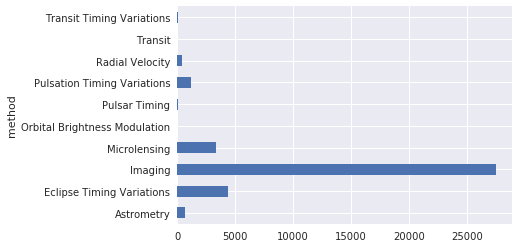

In [26]:
%matplotlib inline
planets.groupby('method')['orbital_period'].median().plot(kind='barh')

#### Iteración sobre grupos

* El objeto ``GroupBy`` soporta la iteración directa sobre grupos, devolviendo cada grupo como una ``Series`` o un ``DataFrame``.


In [28]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1} ".format(method, group.shape))

Astrometry                     shape=(2, 6) 
Eclipse Timing Variations      shape=(9, 6) 
Imaging                        shape=(38, 6) 
Microlensing                   shape=(23, 6) 
Orbital Brightness Modulation  shape=(3, 6) 
Pulsar Timing                  shape=(5, 6) 
Pulsation Timing Variations    shape=(1, 6) 
Radial Velocity                shape=(553, 6) 
Transit                        shape=(397, 6) 
Transit Timing Variations      shape=(4, 6) 


* Si bien podemos hacer este tipo de operaciones de forma manual, veremos enseguida la potencialidad que tienen las funcionalidades ``apply``.

#### Dispatch methods

* Cualquier método no implementado de forma explícita por el objeto ``GroupBy`` será ejecutado en cada grupo.
* Por ejemplo, se puede usar el método ``describe()`` de ``DataFrame``s para realizar muchas operaciones de agregación al interior de cada grupo.

In [33]:
planets.groupby('method')['distance'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
Astrometry,2.0,17.875000,4.094148,14.98,16.4275,17.875,19.3225,20.77
Eclipse Timing Variations,4.0,315.360000,213.203907,130.72,130.7200,315.360,500.0000,500.00
Imaging,32.0,67.715937,53.736817,7.69,22.1450,40.395,132.6975,165.00
Microlensing,10.0,4144.000000,2076.611556,1760.00,2627.5000,3840.000,4747.5000,7720.00
Orbital Brightness Modulation,2.0,1180.000000,0.000000,1180.00,1180.0000,1180.000,1180.0000,1180.00
Pulsar Timing,1.0,1200.000000,NaN,1200.00,1200.0000,1200.000,1200.0000,1200.00
Pulsation Timing Variations,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Radial Velocity,530.0,51.600208,45.559381,1.35,24.4125,40.445,59.2175,354.00
Transit,224.0,599.298080,913.876990,38.00,200.0000,341.000,650.0000,8500.00


* ¿Qué puede decirse de estos datos? 
* Este es solo un ejemplo de la utilidad de estos métodos. Notar que son aplicados a cada uno de los grupos individuales y que los resultados son combinados en un objeto `GroupBy` y retornados.

### Aggregate, filter, transform, apply

* Hay muchas más opciones de operaciones disponibles.
* Los objetos ``GroupBy`` tienen algunos métodos muy útiles: ``aggregate()``, ``filter()``, ``transform()`` y ``apply()`` que implementan muchas operaciones en la etapa previa al "combine"

* Ilustremos estas operaciones con el siguiente ``DataFrame``:

In [36]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


#### Aggregation

* Ya conocemos las agregaciones ``sum()``, ``median()``, pero el método ``aggregate()`` permite una gran flexibilidad:
* Puede tomar un string, una función o una lista y computar todos los agregados en un solo paso.

In [39]:
a = df.groupby('key').aggregate([min, np.median, max])
a

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

* Otra forma útil es pasar un diccionario que mapea nombres de columnas con operaciones. De esta forma, la operación se aplica a cada columna:

In [41]:
a.columns

MultiIndex(levels=[['data1', 'data2'], ['min', 'median', 'max']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])

In [44]:
a.head(2)

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7

In [45]:
df.groupby('key').aggregate({'data1': min,
                             'data2': 'max'})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


#### Filtering

* Una operación filtering permite "descartar" datos basado en propiedades del grupo.
* Por ejemplo, podríamos querer mantener todos los grupos en los que la desviación estándar sea mayor que algún valor de corte:

In [46]:
def filter_func(x):
    return x['data2'].std() > 4

display('df', "df.groupby('key').std()", "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

* La función de filtro retorna un booleano especificando si el grupo pasa o no el filtro. 

#### Transformation

* Mientras que aggregation devuelve una versión reducida de los datos, transformation retorna alguna versión transformada de los datos para, luego, hacer el combine.
* El output de una transformation es del mismo `shape` que el input.

In [47]:
def center_mean(x):
    return(x - x.mean())

print(df.groupby('key').transform(center_mean))
df

   data1  data2
0   -1.5    1.0
1   -1.5   -3.5
2   -1.5   -3.0
3    1.5   -1.0
4    1.5    3.5
5    1.5    3.0


,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


* ¿Qué hace el siguiente bloque de código?

#### El método `apply()`

* El método `apply()` permite aplicar alguna función dada a los resultados del group.
* La función debería tomar como input ``DataFrame`` y devolver un objeto de Pandas (``DataFrame``, ``Series``) o un escalar. 
* La operación combine se adaptará al tipo de salida devuelta.

In [48]:
def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] /= x['data2'].sum()
    return x

display('df', "df.groupby('key').apply(norm_by_data2)")

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9
,key,data1,data2
0,A,0.000000,5
1,B,0.142857,0
2,C,0.166667,3


* ¿Qué operación produce el bloque de código anterior?

### Especificando la clave del "split"

* En el ejemplo anterior se hacía el split del ``DataFrame`` sobre una sola columna.
* Hay otras opciones...

#### Una lista, array, series, o index que contiene las claves del grouping 

In [49]:
L = [0, 1, 0, 1, 2, 0]
display('df', 'df.groupby(L).sum()')

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(L).sum()
   data1  data2
0      7     17
1      4      3
2      4      7

* Por supuesto, hay una mejor manera de lograr esto: ``df.groupby('key')``:

In [50]:
display('df', "df.groupby(df['key']).sum()")


df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(df['key']).sum()
     data1  data2
key              
A        3      8
B        5      7
C        7     12

In [51]:
# Es totalmente equivaliente a
display('df', "df.groupby('key').sum()")


df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').sum()
     data1  data2
key              
A        3      8
B        5      7
C        7     12

#### Un dict o serie mapeando index a grupos

In [52]:
df2 = df.set_index('key')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
consonant,12,19
vowel,3,8


#### Cualquier función de Python 

In [53]:
display('df2', 'df2.groupby(str.lower).mean()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
a,1.5,4.0
b,2.5,3.5


#### Una lista de keys válidas

* Se puede agrupar en base a multi-indexes:

In [54]:
df2.groupby([str.lower, mapping]).mean()

,,data1,data2
a,vowel,1.5,4.0
b,consonant,2.5,3.5
c,consonant,3.5,6.0


### Ejemplo de grouping

* Veamos de qué forma se puede con solamente cuatro líneas de código contar desde el dataset original cuántos planteas fueron descubiertos según cada método por década:

In [64]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum()


method                         decade
Astrometry                     2010s       2
Eclipse Timing Variations      2000s       5
                               2010s      10
Imaging                        2000s      29
                               2010s      21
Microlensing                   2000s      12
                               2010s      15
Orbital Brightness Modulation  2010s       5
Pulsar Timing                  1990s       9
                               2000s       1
                               2010s       1
Pulsation Timing Variations    2000s       1
Radial Velocity                1980s       1
                               1990s      52
                               2000s     475
                               2010s     424
Transit                        2000s      64
                               2010s     712
Transit Timing Variations      2010s       9
Name: number, dtype: int64

In [65]:
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


* Las primeras tres líneas generan el campo `decade`
    1. `planets['year']//10` divide el año por 10 y se queda con la parte entera del cálculo y luego se lo multiplica por 10 para obtener el año
    2. `decade.astype(str) + 's'` lo castea como string y le agrega la "s"
    3. `decade.name = 'decade'`define como nombre "decade"
    

* La última performa el split-apply-combine

In [72]:
planets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
method            1035 non-null object
number            1035 non-null int64
orbital_period    992 non-null float64
mass              513 non-null float64
distance          808 non-null float64
year              1035 non-null int64
dtypes: float64(3), int64(2), object(1)
memory usage: 48.6+ KB
